# This notebook exemplifies the calculation of the reduction to Pole by using the *classical equivalent layer* approach.

In [1]:
# Import all python modules
import numpy
from matplotlib import pyplot

In [2]:
# Import some developed modules
from codes.prism import prism_tf
from codes.sphere import sphere_tfa
from codes.grids import regular_grid
from codes.equivalentlayer import layer, mat_mag_tfa

In [3]:
# Statistical module
from codes.auxiliars import addnoise
from codes.statistical import analysis

In [4]:
# Data shape
ndata = 50
shape = (ndata, ndata)

In [5]:
# Create the regular grid
xo, yo, zo = regular_grid((-2000., 2000., -2000., 2000.), shape, -200.)

In [6]:
# Values for inclination and declination of the magnetic field and the source
inc = 30.
dec = 50.
incs = 1.#20.
decs = 1.#20.

In [7]:
# Define the model
dikemodel = (-300., 150., -100., 280., 100., 750., 1.215)

In [8]:
# Calculate the total field anomaly produced by a rectragular prism as a dike model
tfp = prism_tf(xo, yo, zo, dikemodel, inc, dec, incs, decs)

In [9]:
print 'Analysing total field data:'
_ = analysis(tfp)

Analysing total field data:
Minimum:    -52.3271
Maximum:    32.6120
Mean value: -0.5648
Variation:  84.9391


In [10]:
#tfa = addnoise(tfa, 2., 0.025})
tf = addnoise(tfp, 3., 0.075)

In [11]:
print 'Analysing noised data:'
_ = analysis(tf)

Analysing noised data:
Minimum:    -49.3405
Maximum:    35.5970
Mean value: 2.4364
Variation:  84.9375


#### Creating the layer

In [12]:
# Define a mesh of masses point with unit volume:
# horizontal coordinates:
area = (-2000., 2000., -2000., 2000.) # meters
shape_layer = (60, 60)

In [13]:
# Creating the equivalent layer
eqlayer = layer(area, shape, 700.)

In [14]:
A = mat_mag_tfa(xo, yo, zo, eqlayer, inc, dec, incs, decs)

In [15]:
# dimensions of the sensitivity matrix of the eqlayer problem:
M = shape_layer[0] * shape_layer[1]
N = shape[0] * shape[1]
print 'Number of observations:', N
print 'Number of depth sources:', M

Number of observations: 2500
Number of depth sources: 3600


### Solving the least-squares in two possible cases

In [31]:
# Case1: Overdetermined - Number of observations are greater or equal than the number of depth sources
if N >= M: 
    mu = 0.
    I = numpy.identity(M)
    trace = numpy.trace(A.T.dot(A))/M
    vec = numpy.linalg.solve(numpy.dot(A.T, A) + mu*trace*I, numpy.dot(A.T,tf))
#  case
# Case1: Underterminated - Number of observations are less than the number of depth sources
else:
    mu = 1.e-2
    I = numpy.identity(N)
    trace = numpy.trace(A.T.dot(A))/N
    aux = numpy.linalg.solve(numpy.dot(A, A.T) + mu*trace*I, tf)
    vec = numpy.dot(A.T, aux)

In [32]:
# Computing the predicted data
tf_pred = numpy.dot(A, vec)

In [33]:
print 'Original total field anomaly:'
_ = analysis(tf)
print 'Predicted total field anomaly:'
_ = analysis(tf_pred)

Original total field anomaly:
Minimum:    -49.3405
Maximum:    35.5970
Mean value: 2.4364
Variation:  84.9375
Predicted total field anomaly:
Minimum:    -45.1234
Maximum:    35.2168
Mean value: 2.4260
Variation:  80.3402


In [34]:
from codes.auxiliars import residual

In [35]:
# Computing the residual
res, _, _, _ = residual(tf, tf_pred)

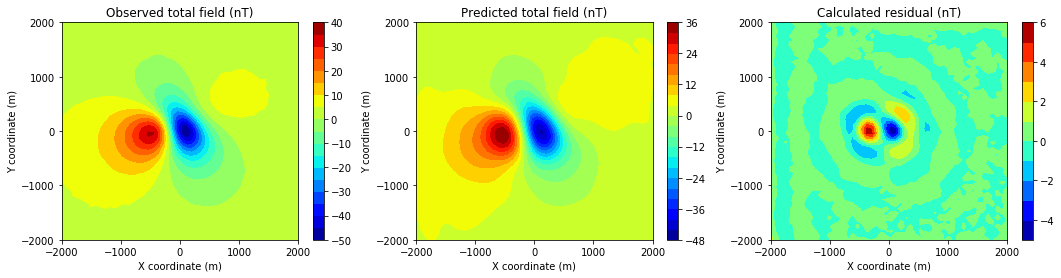

In [36]:
pyplot.figure(figsize=(18, 4))

pyplot.subplot(1, 3, 1)
pyplot.contourf(xo.reshape(ndata,ndata), yo.reshape(ndata,ndata), 
                tf.reshape(ndata,ndata), 20, cmap = pyplot.cm.jet)
pyplot.title('Observed total field (nT)')
pyplot.xlabel('X coordinate (m)')
pyplot.ylabel('Y coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.subplot(1, 3, 2)
pyplot.contourf(xo.reshape(ndata,ndata), yo.reshape(ndata,ndata), 
                tf_pred.reshape(ndata,ndata), 20, cmap = pyplot.cm.jet)
pyplot.title('Predicted total field (nT)')
pyplot.xlabel('X coordinate (m)')
pyplot.ylabel('Y coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.subplot(1, 3, 3)
pyplot.contourf(xo.reshape(ndata,ndata), yo.reshape(ndata,ndata), 
                res.reshape(ndata,ndata), 10, cmap = pyplot.cm.jet)
pyplot.title('Calculated residual (nT)')
pyplot.xlabel('X coordinate (m)')
pyplot.ylabel('Y coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.show()

### Applying the reduction to Pole by using Equivalent Layer

In [37]:
# Define the new directions
inc_polo = 90.
dec_polo = 0.

In [38]:
# Computing the true total field anomaly at the Pole
true_rtp = prism_tf(xo, yo, zo, dikemodel, inc_polo, dec_polo)

In [39]:
# Import the RTP function
from codes.filtering import reduction

In [40]:
# Computing by Fourier
fourier_rtp = reduction(xo.reshape(ndata,ndata), yo.reshape(ndata,ndata), 
                        tfp.reshape(ndata,ndata), inc, dec, incs, decs)

In [41]:
# Computing bu equivalent layer
A_rtp = mat_mag_tfa(xo, yo, zo, eqlayer, inc_polo, dec_polo, inc_polo, dec_polo)

In [42]:
# Reduction to Pole
layer_rtp = numpy.dot(A_rtp, vec)

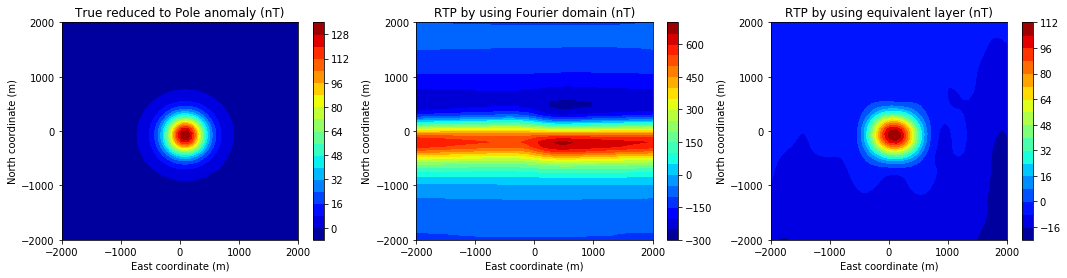

In [43]:
# Plotting the result
pyplot.figure(figsize=(18, 4))

pyplot.subplot(1, 3, 1)
pyplot.contourf(yo.reshape(ndata,ndata), xo.reshape(ndata,ndata), 
                true_rtp.reshape(ndata, ndata), 20, cmap = pyplot.cm.jet)
pyplot.title('True reduced to Pole anomaly (nT)')
pyplot.xlabel('East coordinate (m)')
pyplot.ylabel('North coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.subplot(1, 3, 2)
pyplot.contourf(yo.reshape(ndata,ndata), xo.reshape(ndata,ndata), 
                fourier_rtp, 20, cmap = pyplot.cm.jet)
pyplot.title('RTP by using Fourier domain (nT)')
pyplot.xlabel('East coordinate (m)')
pyplot.ylabel('North coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.subplot(1, 3, 3)
pyplot.contourf(yo.reshape(ndata,ndata), xo.reshape(ndata,ndata), 
                layer_rtp.reshape(ndata,ndata), 20, cmap = pyplot.cm.jet)
pyplot.title('RTP by using equivalent layer (nT)')
pyplot.xlabel('East coordinate (m)')
pyplot.ylabel('North coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.show()